# Landscaping Startups in Portland, Oregon, United States

### Summary

Foursquare venue category information and Portland's civic office data were used to cluster the city's neighborhoods. In an effort to find which neighborhoods have a greater amount of natural and artificial landscapes, the data was clustered using a KMeans algorythm. Results indicate the best neighborhoods for further research are:


Arlington Heights,
 Arnold Creek,
 Brentwood/Darlington,
 Forest Park,
 Healy Heights,
 Hillside,
 Marshall Park,
 Northwest Heights,
 Pleasant Valley,
 Southwest Hills,
 Wilkes

### Business Problem

The neighborhoods in the city of Portland often have a variety of natural and artificial landscapes that need stewardship and maintenance. Venues may include parks, garden centers, country clubs, florists, hardware stores, private residences, and any business that caters to creating, maintaining, and managing vegetation and landscapes. 

A hypothetical group of investors is looking to start a landscaping business that maintains, desings, and installs vegetation in public and private spaces. It would behoove this group of stakeholders to determine in which neighbourhoods they find the most amount of these locations. 

This information would allow them to decide where they should place their new landscaping business; such that travel times between clients and appointments is reduced and their ability to reach customers improves. On the other hand, venue category may provide useful intelligence for deciding which neighborhood is closest to businesses the sell the inputs the startup will need more ocassionally: seed, plants, fertilizer, pesticides, or similar hardware.  Likewise, results may also allow them to determine in which neighborhoods they should spend resources researching the market and possible competitors.

![This landscape could use some mowing](https://img.timeinc.net/time/2010/portland_tavel/portland_park.jpg)

<p style="text-align: center;">A park in the city of Portland that could use a mowing.</p>

### Data

We will use Foursquare location data to access venue categories in Portland. We will determine neighborhood locations in the city of Portland by scraping several lists from the [Neighborhoods of Portland, Oregon](https://www.portlandoregon.gov/civic/35281) site. The list will be sorted and cleaned so that we can parse it to the geocoder and determine geographical locations for each neighborhood. Following this, we will explore each neighborhood within a 1000 m radius for venues. We will categorize the venues and determine which categories are most related to landscaping and gardening businesses. We will classify each neighborhood according to their rate of landscaping-related businesses. This will allow us to make a recommendation for which neighborhoods the investors should pay closer attention to.

## 1. Preparing Data


### 1.1 Required Packages

In [324]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import silhouette score for finding the best K value
from sklearn.metrics import silhouette_score

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


from bs4 import BeautifulSoup # We use beautiful soup to scrape the website from Portland's local government site



print('Libraries imported.')

Libraries imported.


### 1.2 Fetching and cleaning Portland neighborhood information

We need to access local government data to have accurate location information for each community.

In [325]:
site = 'https://www.portlandoregon.gov/civic/35281'
nhs = requests.get(site)
soup = BeautifulSoup(nhs.text, "html.parser")

nhs_list = soup.find_all("h2")


portland = []

for child in nhs_list: # For loop produces the strings in all the 'h2' tags of our soup
    portland.append(child.string)
    show = pd.DataFrame(data = {'Neighborhood' : portland} )


Select only the rows that have the string *Neighborhood* in them. Then eliminate all the strings so that we are left only with the neighborhood name.

In [326]:
df = show

string_cleaning = [' Neighborhood Association',
                   ' Neighborhood District Association',
                   ' \(formerly CTLH\)', 
                   ' Neighborhood Network',
                   ' Association of Neighbors',
                   ' Association of Neighborhoods',
                   ' \(HAND \)',
                   ' Community Association',
                   ' Improvement League \(SMILE\)',
                   ' Residential League',
                   ' Community Group',
                   ' Association',
                   ' League',
                   ' Action Corps',
                   ' Foothills']


We loop through our list of neighborhood strings and trim away whatever strings we find that are on our cleaning list.

In [327]:
x = df.Neighborhood

for i in string_cleaning:
    x = x.str.replace(r'{}'.format(i), '')
    df = pd.DataFrame(data = {'Neighborhood':x} )

Some additional tidying up is necessary. Dropping irrelevant fields and resetting the index are good practices.

In [328]:
df = df.drop(0)
df.reset_index(drop=True, inplace = True)
df = df.drop(87) # University Park is not showing up in the geocoding for Portland. We will drop it
df.reset_index(drop=True, inplace = True)

In [329]:
print(df.head(9))
print('There are ', df.shape[0], 'neighborhoods in Portland Oregon')

              Neighborhood
0                  Alameda
1              Arbor Lodge
2  Ardenwald/Johnson Creek
3            Argay Terrace
4        Arlington Heights
5             Arnold Creek
6                 Ashcreek
7        Beaumont-Wilshire
8                    Boise
There are  93 neighborhoods in Portland Oregon


## 2. Obtaining coordinates for each neighborhood

Here we create empty list for strings and integer types. We will fill them with the results of the geocoder.

In [330]:
loc = np.full(df.shape[0], '                                   ')
lat = np.full(df.shape[0], np.nan)
long = np.full(df.shape[0], np.nan)


This loop sends adress information to Nominatim. It returns latitude and longitude values that we need to store and later work with.

In [331]:

for i in range(0,df.shape[0]):
    nh = df['Neighborhood'][i]
    adress = '{}, Portland, OR'.format(nh)
#    
    geolocator = Nominatim(user_agent = "portland_explorer")
    location = geolocator.geocode(adress)
#    
#    print(location)   Uncomment this line to test for geocoding errors. If geolocator cannot parse the location it will return None.
#    
    loc[i]= nh
    lat[i]= location.latitude
    long[i]= location.longitude
#    
    portland_data = pd.DataFrame(data = {'Neighborhood':loc, 'Latitude':lat, 'Longitude':long})
                
print('Geocoding finished.')

Geocoding finished.


Observe we have added location data and the number of communities remain the same.

In [332]:
print(portland_data.head())
print(portland_data.shape)

              Neighborhood   Latitude   Longitude
0                  Alameda  45.548631 -122.636481
1              Arbor Lodge  45.571794 -122.690152
2  Ardenwald/Johnson Creek  45.458516 -122.627539
3            Argay Terrace  45.552830 -122.523204
4        Arlington Heights  45.519496 -122.710667
(93, 3)


We have the locations for every neighborhood in Portland. Let's visualize them on the map.

## 3. Looking at the neighborhoods of Portland on a map

In [162]:
# create map of Portland using latitude and longitude values
adress = 'Portland, OR, United States'
#    
geolocator = Nominatim(user_agent = "portland_explorer")
location = geolocator.geocode(adress)

latitude = location.latitude
longitude = location.longitude


In [164]:

map_portland = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(portland_data['Latitude'], portland_data['Longitude'], portland_data['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_portland)  
    
map_portland

## 4. Pulling Foursquare API Data to cluster neighborhoods together

### 4.1 This is our Foursquare login data:

In [165]:
CLIENT_ID = 'DPWCOUVPHFC1O2VUBQEOAJLAV21H3D4LVTW3DJIT4IFLNO1K' # your Foursquare ID
CLIENT_SECRET = 'I4WDHEVW0CXU2CN4DHP51NN1ASV40RKVYPW15QU3P3IJ1F0J' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version 20120609

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPWCOUVPHFC1O2VUBQEOAJLAV21H3D4LVTW3DJIT4IFLNO1K
CLIENT_SECRET:I4WDHEVW0CXU2CN4DHP51NN1ASV40RKVYPW15QU3P3IJ1F0J


### 4.2 Looking at venues for one neighborhood

Let's explore the first neighborhood in the data set. We will fetch the top 100 venues in Alameda, Portland.

In [174]:
radius = 1000
LIMIT = 100

neighborhood_latitude = portland_data.loc[0,'Latitude']
neighborhood_longitude =  portland_data.loc[0,'Longitude']

# Setting up the fetch request for Foursquare
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neighborhood_latitude,
    neighborhood_longitude, 
    radius, 
    LIMIT)

# Showing the results from the get-request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f554001bf216839f1c38f5e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Alameda',
  'headerFullLocation': 'Alameda, Portland',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 16,
  'suggestedBounds': {'ne': {'lat': 45.55763070900001,
    'lng': -122.62365301411066},
   'sw': {'lat': 45.539630690999985, 'lng': -122.64930818588934}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5908a538002f4c7894e0e5ca',
       'name': 'Guilder',
       'location': {'address': '2393 NE Fremont St',
        'lat': 45.54829,
        'lng': -122.641335,
        'labeledLatLngs': [{'label': 'display',
          'lat': 45.54829,
          'lng':

We can already see a soccer field and a garden center in this neighborhood. These venue categories are a good fit for landscaping businesses. We will use a function that extracts the category type for each venue in the get-request. This will allow us to go through each neighbor and extract the category types of the top venues there.

In [175]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [176]:

# Here we clean the json object and put it into a data frame

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Guilder,Coffee Shop,45.548290,-122.641335
1,Lucca,Italian Restaurant,45.548167,-122.641375
2,Garden Fever,Garden Center,45.548010,-122.641359
3,Wilshire Park,Park,45.553083,-122.627198
4,Tacovore,Taco Place,45.548444,-122.624638
5,Fremont Family Vision,Optical Shop,45.548040,-122.640572
6,Wild Pet Provisions,Pet Store,45.548303,-122.641352
7,Madeleine Parish Turf Soccer Field,Soccer Field,45.546882,-122.641662
8,TriMet Bus Line 24,Bus Line,45.548481,-122.630690
9,Tacos Pa'ella Mexican Food,Food Truck,45.555298,-122.638006


### 4.3 Scaling category extraction for venues in all the neighborhoods in Portland

This is a function that repeats category extraction along the portland_data object.

In [199]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print(nearby_venues.shape[0], 'venues were found and indexed for the city of Portland.')
    return(nearby_venues)

In [200]:
portland_venues = getNearbyVenues(names=portland_data['Neighborhood'],
                                   latitudes=portland_data['Latitude'],
                                   longitudes=portland_data['Longitude']
                                  )

4150 venues were found and indexed for the city of Portland.


In [201]:
portland_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alameda,45.548631,-122.636481,Guilder,45.548290,-122.641335,Coffee Shop
1,Alameda,45.548631,-122.636481,Lucca,45.548167,-122.641375,Italian Restaurant
2,Alameda,45.548631,-122.636481,Garden Fever,45.548010,-122.641359,Garden Center
3,Alameda,45.548631,-122.636481,Wilshire Park,45.553083,-122.627198,Park
4,Alameda,45.548631,-122.636481,Tacovore,45.548444,-122.624638,Taco Place


### 4.3 Looking at venue distribution in the neighborhoods

How many venues were returned for every neighborhood?

In [202]:
portland_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alameda,16,16,16,16,16,16
Arbor Lodge,51,51,51,51,51,51
Ardenwald/Johnson Creek,18,18,18,18,18,18
Argay Terrace,9,9,9,9,9,9
Arlington Heights,50,50,50,50,50,50
Arnold Creek,3,3,3,3,3,3
Ashcreek,6,6,6,6,6,6
Beaumont-Wilshire,44,44,44,44,44,44
Boise,100,100,100,100,100,100


We see some neighborhoods reach our get-request limit of 100 while others barely register any indexing.

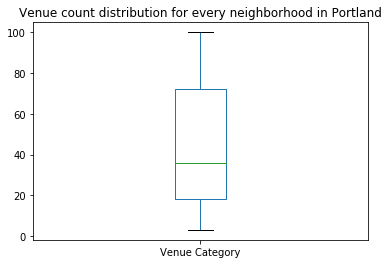

In [215]:
import matplotlib.pyplot as plt

portland_venues.groupby('Neighborhood').count()['Venue Category'].plot.box(title="Venue count distribution for every neighborhood in Portland")


50% of the neighborhoods have between 20 and 70 venues indexed. 20% of the neighborhoods have 20 or less venues. These areas may be less densely populated or more exposed to natural landscapes. It is important to mention this because these neighbourhoods could not be properly represented.

How many categories are there in these neighborhoods?

In [218]:
print('There are {} unique categories.'.format(len(portland_venues['Venue Category'].unique())))


There are 329 unique categories.


### 4.3 Looking at each neighborhood

We perform one hot encoding for venue categories. This is an antecedent for calculating the ocurrence of the venue categories for each neighborhood.

In [270]:
# one hot encoding
portland_onehot = pd.get_dummies(portland_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe

portland_onehot = portland_onehot.rename(columns={'Neighborhood': 'Neighborhood_'}) # For some reason 'Neighborhood' was one of the categories our get-request fetched.

portland_onehot['Neighborhood'] = portland_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [portland_onehot.columns[-1]] + list(portland_onehot.columns[:-1])
portland_onehot = portland_onehot[fixed_columns]

portland_onehot.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood_,New American Restaurant,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restau

## 5. Calculating venue category frequency in each neighborhood

In this part we group the venue categories by neighborhood and determine their frequency. This will allow us to see which venue categories are more common in the communities. With this we can feed our clustering algorithm and create m

In [271]:
portland_grouped = portland_onehot.groupby('Neighborhood').mean().reset_index()
portland_grouped

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Airport,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Credit Union,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hockey Arena,Home Service,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood_,New American Restaurant,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restau

With this information we can calculate the most common venues in each neighborhood.

In [273]:
# This function sorts venue frequency descendingly

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [312]:
# This cell parses the function through the portland_grouped data

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = portland_grouped['Neighborhood']

for ind in np.arange(portland_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(portland_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Bus Stop,Taco Place,Italian Restaurant,Garden Center,Park,Coffee Shop,Pet Store,Soccer Field,Optical Shop,Business Service
1,Arbor Lodge,Coffee Shop,Mexican Restaurant,Park,Pizza Place,Chinese Restaurant,Bar,Thai Restaurant,BBQ Joint,Supermarket,Grocery Store
2,Ardenwald/Johnson Creek,Grocery Store,Park,Convenience Store,Coffee Shop,Furniture / Home Store,Café,Tennis Court,Light Rail Station,Trail,Athletics & Sports
3,Argay Terrace,Pizza Place,Thai Restaurant,Park,Convenience Store,Bar,Mexican Restaurant,Warehouse Store,Fast Food Restaurant,Event Service,Event Space
4,Arlington Heights,Trail,Park,Garden,Botanical Garden,Gift Shop,Train Station,Playground,Amphitheater,Bank,Public Art


We can already see at least one neighborhood - Arlington Heights - where the most common venues are trails, parks, gardens, and landscapes. The other neighborhoods have parks as at least the 3rd most common venue.

### 6. Clustering neighborhoods using KMeans 

We will run cluster the neighborhoods using kmeans. What is the optimum value for K? We will evaluate this using the silhouette score for the fit.

In [313]:
portland_grouped_clustering = portland_grouped.drop('Neighborhood', 1)

eval_score = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(portland_grouped_clustering)
  labels = kmeans.labels_
  eval_score.append(silhouette_score(portland_grouped_clustering, labels, metric = 'euclidean'))

eval_score

[0.4040311279021875,
 0.3565024170681342,
 0.362541277324647,
 0.23942386695438297,
 0.1874062388340388,
 0.06647567991109615,
 0.09134140424490736,
 0.13557122738091268,
 0.05209069286051518]

We can see the best value for K is either 2 or 3. Let's how it works with 2 labels.

In [314]:

# set number of clusters
kclusters = 2

portland_grouped_clustering = portland_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(portland_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0], dtype=int32)

Let's add the cluster labels to our portland neighborhoods.

In [315]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

portland_merged = portland_data

portland_merged = portland_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

portland_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,45.548631,-122.636481,1,Bus Stop,Taco Place,Italian Restaurant,Garden Center,Park,Coffee Shop,Pet Store,Soccer Field,Optical Shop,Business Service
1,Arbor Lodge,45.571794,-122.690152,1,Coffee Shop,Mexican Restaurant,Park,Pizza Place,Chinese Restaurant,Bar,Thai Restaurant,BBQ Joint,Supermarket,Grocery Store
2,Ardenwald/Johnson Creek,45.458516,-122.627539,1,Grocery Store,Park,Convenience Store,Coffee Shop,Furniture / Home Store,Café,Tennis Court,Light Rail Station,Trail,Athletics & Sports
3,Argay Terrace,45.552830,-122.523204,1,Pizza Place,Thai Restaurant,Park,Convenience Store,Bar,Mexican Restaurant,Warehouse Store,Fast Food Restaurant,Event Service,Event Space
4,Arlington Heights,45.519496,-122.710667,0,Trail,Park,Garden,Botanical Garden,Gift Shop,Train Station,Playground,Amphitheater,Bank,Public Art


## 7. Visualizing neighborhood clusters

The following map will show how the different neighborhoods where clustered together. Then we will look at the definning characteristics of each cluster.

In [316]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(portland_merged['Latitude'], portland_merged['Longitude'],
                                  portland_merged['Neighborhood'], portland_merged['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can identify cluster 0 is significantly larger than the other ones. 10 neighborhoods are cluster 2 and 2 neighborhoods are cluster 1.

### 7.1 Characterizing the clusters

Here we examine how each cluster is made up. We will look for defining features.

#### Cluster 0

In [319]:
df = portland_merged.loc[portland_merged['Cluster Labels'] == 0, portland_merged.columns[[0] + list(range(4, portland_merged.shape[1]))]]
df

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Arlington Heights,Trail,Park,Garden,Botanical Garden,Gift Shop,Train Station,Playground,Amphitheater,Bank,Public Art
5,Arnold Creek,Park,Moving Target,Fast Food Restaurant,Zoo Exhibit,Field,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market
9,Brentwood/Darlington,Park,Convenience Store,Restaurant,Thai Restaurant,Grocery Store,Dog Run,Trail,Deli / Bodega,Ice Cream Shop,Farmers Market
25,Forest Park,Trail,National Park,Field,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market
33,Healy Heights,Trail,Park,Bus Line,Carpet Store,Breakfast Spot,Flower Shop,Farmers Market,Food,Ethiopian Restaurant,Event Service
35,Hillside,Trail,Park,Scenic Lookout,Bus Station,Gift Shop,Thai Restaurant,Café,Dive Bar,Music Venue,Gym
51,Marshall Park,Park,Yoga Studio,Construction & Landscaping,Fast Food Restaurant,Zoo Exhibit,Field,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor
59,Northwest Heights,Coffee Shop,Restaurant,Trail,Soccer Field,Pizza Place,Park,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Elementary School
66,Pleasant Valley,Park,Garden,Dance Studio,Event Service,Filipino Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant
80,Southwest Hills,Zoo Exhibit,Trail,Park,Gift Shop,Zoo,Scenic Lookout,Performing Arts Venue,Museum,Food Truck,Gas Station


Cluster 0 has an excellent selection of natural and artificial landscapes that could be serviced by the start up. We can easily appreciate parks, gardens, and trails as the most common venues in the cluster. There are farmers markets, event spaces, fields and venues that could be enhanced by bespoke landscaping services.

It would be in the investors best interests to look closer into this neighborhoods and determine if there are opportunities for a landscaping startup.

These are the neighborhoods that belong to cluster 0:

In [322]:
list(df.Neighborhood)

['Arlington Heights',
 'Arnold Creek',
 'Brentwood/Darlington',
 'Forest Park',
 'Healy Heights',
 'Hillside',
 'Marshall Park',
 'Northwest Heights',
 'Pleasant Valley',
 'Southwest Hills',
 'Wilkes']

#### Cluster 1

In [321]:
portland_merged.loc[portland_merged['Cluster Labels'] == 1, portland_merged.columns[[0] + list(range(4, portland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Bus Stop,Taco Place,Italian Restaurant,Garden Center,Park,Coffee Shop,Pet Store,Soccer Field,Optical Shop,Business Service
1,Arbor Lodge,Coffee Shop,Mexican Restaurant,Park,Pizza Place,Chinese Restaurant,Bar,Thai Restaurant,BBQ Joint,Supermarket,Grocery Store
2,Ardenwald/Johnson Creek,Grocery Store,Park,Convenience Store,Coffee Shop,Furniture / Home Store,Café,Tennis Court,Light Rail Station,Trail,Athletics & Sports
3,Argay Terrace,Pizza Place,Thai Restaurant,Park,Convenience Store,Bar,Mexican Restaurant,Warehouse Store,Fast Food Restaurant,Event Service,Event Space
6,Ashcreek,Trail,Coffee Shop,Food,Home Service,Marijuana Dispensary,Optical Shop,Escape Room,Ethiopian Restaurant,Event Service,Event Space
7,Beaumont-Wilshire,Café,Coffee Shop,Bar,Pizza Place,Thai Restaurant,Breakfast Spot,Bus Stop,Grocery Store,Print Shop,Taco Place
8,Boise,Food Truck,Bar,Pizza Place,Coffee Shop,Mexican Restaurant,Cocktail Bar,Gift Shop,Brewery,Ice Cream Shop,Beer Garden
10,Bridgeton,Harbor / Marina,Deli / Bodega,American Restaurant,Baseball Field,Convenience Store,Bar,Dog Run,Kitchen Supply Store,Park,Motel
11,Bridlemile,Mexican Restaurant,Coffee Shop,Sports Bar,Gastropub,Marijuana Dispensary,BBQ Joint,Auto Workshop,Grocery Store,Gym,Pharmacy
12,Brooklyn,Bar,Park,Pizza Place,Grocery Store,Café,Convenience Store,River,Theater,Light Rail Station,Lounge


It looks like cluster 0 - or most of the city - is composed of service and food industries. Some parks but not a lot of them. There may be some opportunities with hotels but this cluster is definitly not ripe with opportunity for our endeavour.